![8th International Summer School on Computational Interaction](imgs/header.png)

# 2: Exercise
**John H. Williamson**

In the exercise, we will experiment with both **forward** and **backward** models. We'll have the live link to the keyboard fist sensor, and you'll be able to test different approaches to interpreting the sensor vector.

## FAQ
* I can't run the keyboard model! 
    * Check if the `sudo` option helps (needed on Linux). If not, find someone else who can run the demo!
* I can run the keyboard model, but it doesn't connect to the machine learning!
    * This is probably a firewall issue on your laptop. You need to allow port 5556 for localhost traffic.
* The predictions are bad!
    * Yes, the default settings are not especially optimal :)

In [9]:
%load_ext autoreload
%autoreload 2

In [18]:
# Global imports (remember to run this cell!)
import sys 
sys.path = ['src'] + sys.path
from flax import linen as nn
from flax.training import train_state
import optax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from zmqutils import safe_launch
from sklearn.model_selection import train_test_split
import jax 


In [34]:
from zmqutils import sync_rep_loop

def prediction_loop(predict_fn, port=5556):
    # synchronous reply loop -- receive touch events and reply with predictions
    def loop_fn(touch_input):
        # respond to touch events
        if "touch" in touch_input:            
                # decode it, predict and send a response
                x = np.array(touch_input["touch"]).astype(np.float32).reshape(1, 270)
                seq = touch_input["seq"]
                y = predict_fn(x)
                msg = {"target": {"x": float(y[0,0]), "y": float(y[0,1]), "radius":float(y[0,2])}, "seq":seq}
                print(f"{seq}                     \r", end="")
                return msg
        # queue shutdown
        if "quit" in touch_input:
                raise StopIteration
    sync_rep_loop(port, loop_fn)

def offset_plot(true, predicted):
    # plot lines between the predicted and actual points
    fig, ax = plt.subplots(figsize=(15, 4.5))
    ax.scatter(true[:, 0], true[:, 1], label="Actual", marker='x')
    predictions = mlp_state.apply_fn(mlp_state.params, X_test)
    ax.scatter(predicted[:, 0], predicted[:, 1], label="Predicted", marker='o')
    for i in range(len(y_test)):
        ax.plot([true[i, 0], predicted[i, 0]], [true[i, 1], predicted[i, 1]], color='black', alpha=0.1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()

## 2 (a) Direct inverse model
The code below allows you to train and test a direct inverse model. 

Things you can do:
* Capture more or new data from the live capture; (you could merge multiple CSV files just by con catenating them, if you want to do this as a group)
* Capture data from the **simulator**. You can configure the number of frames to simulate and the parameters of the simulator.
* Change the hyperparameters of the model (e.g. learning rate, iterations, etc.) and the loss function
* Adjust the network itself (e.g. change the number of layers, activations, size of layers, use convolutional layers, etc.)

You can then run the model live against the touch simulator and see how well it works :)

### 2(a) Data capture

You can either use my original data (`data/clean.csv`) or generate your own data using the following code.  

To generate data:
* uncomment the `safe_launch` line below. 
* The keyboard interface will appear
* Press your fist somewhere!
* Click with the mouse on the centre point of the target
* Keep doing this until you are bored.
* Press `CTRL-ESC ESC` to quit the capture
* Note: calling `safe_launch` will append to the data file each time it is called. Use `--overwrite` to force it to be rewritten.

In [11]:
# add "--overwrite" to the arguments if you want to overwrite the file
# safe_launch("src/key_demo.py", args=["--file", "data/my_fistpointer_data.csv"], timeout=1000)
# data_file = "data/my_fistpointer_data.csv" # your data 

Or, you can use the simulator to generate new data (it will also append to any existing data file):

In [23]:
from key_model import batch_simulate

# you can modify these parameters; noise, size and intensity are most relevant
simulator_params = {
    "out_file" : "data/sim_data.csv", # output file
    "n": 1000, # number of samples
    "x_sampler": lambda: np.random.uniform(0, 1), # x coordinate sampling
    "y_sampler": lambda: np.random.uniform(0, 1), # y coordinate sampling
    "size_sampler": lambda: np.random.uniform(0.02, 0.05), # size sampling
    "intensity_sampler": lambda: np.random.uniform(0.8, 2), # intensity sampling
    "noise":0.001, # noise level
}

# leave size and slc as they are
# uncomment to run the simulation
#batch_simulate(size=32, slc=[9,30], **simulator_params)


In [22]:
# SET THE DATA FILE TO THE DATA YOU WANT TO USE HERE 
data_file = "data/sim_data.csv" # my data at the moment

# Data preprocessing -- you shouldn't need to change this cell
data = np.loadtxt(data_file, delimiter=",").astype(np.float32)
print(f"Read data with shape {data.shape} from {data_file}")
# split the features from the targets
data_features, data_targets = data[:, :-2], data[:, -2:]
# split into test and train
X_train, X_test, y_train, y_test = train_test_split(data_features, data_targets, test_size=0.2, random_state=42)
print(f"Training data has {len(X_train)} samples, test data has {len(X_test)} samples")
assert X_train.shape[1] == 270 and y_train.shape[1] == 2, "Data has the wrong shape"
assert X_test.shape[1] == 270 and y_test.shape[1] == 2, "Data has the wrong shape"
print("Data read and split successfully")


Read data with shape (2000, 272) from data/sim_data.csv
Training data has 1600 samples, test data has 400 samples
Data read and split successfully


### 2(a) Parameters
You can vary the settings below to change the training and testing behaviour.

In [27]:
# Hyperparameters for training
direct_params = {
    "learning_rate":0.001, 
    "iterations":1000,
    "batch_size":32,
    }

# Define the loss function (MSE)
# You can change this if you wish!
def mse_loss(predictions, targets):
    return jnp.mean((predictions - targets) ** 2)

# Define the MLP model
class MLP(nn.Module):
    # 270 - 32 -> 2 dimensions
    @nn.compact
    def __call__(self, x):
        # x will be a (batch, 270) element tensor
        x = nn.Dense(features=32)(x)
        x = nn.swish(x)
        x = nn.Dense(features=2)(x)  # Output layer with 2 dimensions
        return x

### 2(a) Training
You don't need to modify the cell below usually. You can run it to train the model.

In [28]:
# Leave this cell as it is, unless you are doing something clever!
# Define a function to create the train state
def create_MLP(rng, learning_rate):
    model = MLP()
    params = model.init(rng, jnp.ones((1, 270)))  
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Define the evaluation function (for testing)
def evaluate(state, batch):
    predictions = state.apply_fn(state.params, batch['inputs'])
    loss = mse_loss(predictions, batch['targets'])
    return loss

# predict an output from a single
def predict(state, single_input):
    single_input = single_input.reshape(1, -1)  # Ensure the input has the shape (1, 270)
    prediction = state.apply_fn(state.params, single_input)
    return prediction

# One training step
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        predictions = state.apply_fn(params, batch['inputs'])
        loss = mse_loss(predictions, batch['targets'])
        return loss    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Train the model
rng = jax.random.PRNGKey(42)
learning_rate = direct_params["learning_rate"]
mlp_state = create_MLP(rng, learning_rate)
batch = {'inputs': X_train, 'targets': y_train}

# train loop
for i in range(direct_params["iterations"]):
    mlp_state, loss = train_step(mlp_state, batch)
    if i % 100 == 0:
        print(f'Step {i}, Loss {loss}')

Step 0, Loss 0.33457788825035095
Step 100, Loss 0.035347308963537216
Step 200, Loss 0.02405136078596115
Step 300, Loss 0.0189578365534544
Step 400, Loss 0.016650961712002754
Step 500, Loss 0.015105372294783592
Step 600, Loss 0.01395952794700861
Step 700, Loss 0.013045216910541058
Step 800, Loss 0.012259313836693764
Step 900, Loss 0.011557887308299541


### 2(a) Offline testing
The tests below will give you some idea of how well your model works (but no substitute for live testing!).


Test loss: 0.0177


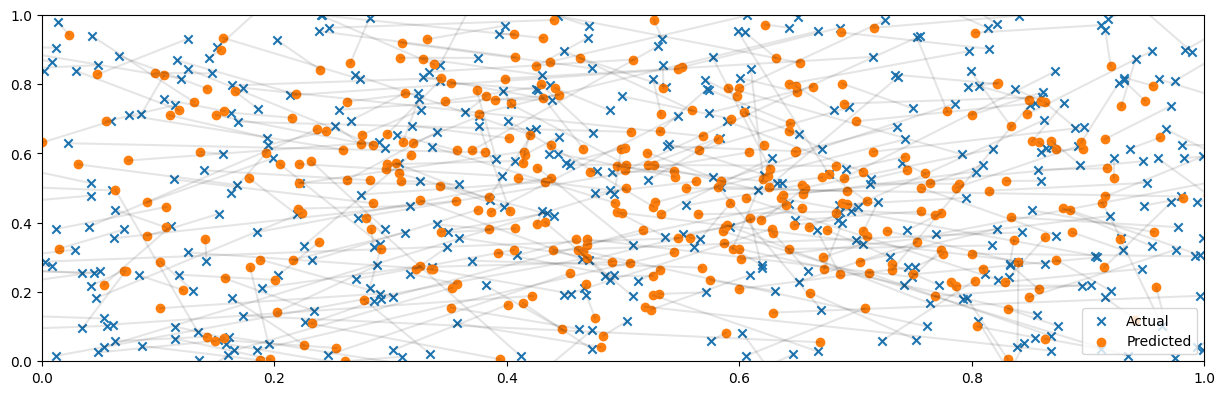

In [32]:
# Evaluate the model, and plot some examples
test_batch = {'inputs': X_test, 'targets': y_test}
test_loss = evaluate(mlp_state, test_batch)
print(f'Test loss: {test_loss:.4f}')



predicted = mlp_state.apply_fn(mlp_state.params, X_test)
offset_plot(y_test, predicted)


### 2(a) Live testing

In [36]:
# CTRL-ESC to exit!
safe_launch("src/key_demo.py", args=["--zmq_port", "5556"], timeout=0)

def predict(y):
    x = np.array(y).astype(np.float32).reshape(1, 270)
    y = predict(mlp_state, x)
    y = np.concatenate([y, np.array([0.05])], axis=1) # add fixed radius
    return y

prediction_loop(predict, port=5556)

142                     


## 2 (b) Bayesian inversion with a particle filter

Things you can do:
* Change the hyperparameters (e.g. number of particles, prior sampling proportion)
* Adjust the likelihood function (e.g. tweak the kernel, replace it with something else)
* Adjust the dynamics model (e.g. increase variance of the dynamics, or change the dynamics model entirely)
* **very ambitious** fuse the direct inverse in 2(a) with 2(b) to get a better estimate of the touch location

### 2(b) Parameters

### 2(b) Training

### 2(b) Offline testing

### 2(b) Live testing